# Overview
* Here we will load the trained model and test it wih custom inputs.
* We will try to explain which feature is contributing the most when a particular emotion is predicted

### 1.  Importing Libraries

In [16]:
!pip install captum
from captum.attr import LayerIntegratedGradients
import torch
import transformers
from transformers import BertTokenizer
import numpy as np
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from google.colab import drive
drive.mount("/content/drive/")
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 2. Intializing Parameters

In [10]:
MAX_LEN = 50
TRAIN_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

emotions_dict = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'
}

### 3.1. Defining Model class to load weights later

In [3]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-multilingual-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 28)

    def forward(self, input_ids, mask, token_type_ids):
        _, output_1= self.l1(input_ids = input_ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

### 3.2. Loading the model with previously saved weights

In [4]:
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/model.pt")) # if GPU
# model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/model.pt"), map_location=torch.device('cpu')) # if CPU

<All keys matched successfully>

### Preparing Custom Dataset for inference

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = X
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [7]:
data = CustomDataset(["I can only give one thing that is my heart"], tokenizer, MAX_LEN)
infer = DataLoader(data)

### 4. Testing with a custom `input_text` to predict an emotion

In [8]:
for _, data in enumerate(infer):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    with torch.inference_mode():
        outputs = model(ids, mask, token_type_ids)

In [14]:
print(f"Predicted Emotion : {emotions_dict[torch.argmax(outputs[0]).item()].capitalize()}")

Predicted Emotion : Neutral


### 5. Explain the prediction results with `Saliency Map`
Here we will
- Define the baseline (reference) for integrated gradients
- Instantiate the `LayerIntegratedGradients` object to find the gradient against a feature from last layer of the model
- Plot the saliency map using a heatmap
---
- Refer to [here](https://https://santiagof.medium.com/model-interpretability-making-your-model-confesses-saliency-maps-5b14c1e04f9e#:~:text=The%20idea%20behind%20the%20saliency,the%20distribution%20of%20such%20activity.) to know more about `Saliency Maps`

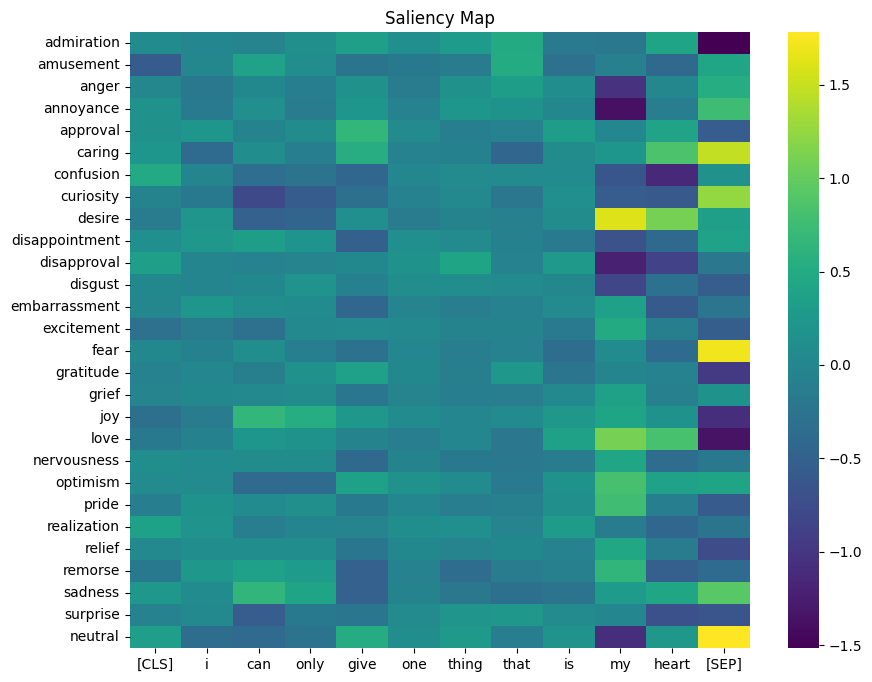

In [19]:
tokens = tokenizer.encode_plus("I can only give one thing that is my heart", return_tensors='pt', add_special_tokens=True)
input_ids = tokens['input_ids'].to(device)
attention_mask = tokens['attention_mask'].to(device)
token_type_ids = tokens['token_type_ids'].to(device)

ref_token_id = tokenizer.pad_token_id
ref_input_ids = torch.tensor([[ref_token_id] * input_ids.shape[1]]).to(device)

lig = LayerIntegratedGradients(model, model.l1.embeddings)

tar = range(28)
attributions = [lig.attribute(inputs=(input_ids, attention_mask, token_type_ids),
                                    baselines=(ref_input_ids, torch.zeros_like(attention_mask), torch.zeros_like(token_type_ids)),
                                    target=i).squeeze(0).detach().cpu().numpy().sum(axis=1) for i in tar]

ticky = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

plt.figure(figsize=(10, 8))
sns.heatmap(attributions, xticklabels=[tokenizer.decode(token_id).replace(" ", "") for token_id in tokens['input_ids'][0]], cmap="viridis", yticklabels=ticky)
plt.title('Saliency Map')
plt.show()